### Fine-scale diversity due to satellite niches in ecosystems with boom-and-bust cycles

It has long been known that more than one strains with similar functions can coexist in both natural and lab environments, yet the mechanism behind remains as a puzzle. Here, we propose a model to study this coexitence, where strains that obey Monod's growth law undergo boom and bust cycles. 

### Here, we start from the simple case of 2 strains coexisting in 1 resource. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import copy
import pickle
from math import *
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

%matplotlib inline

In [2]:
# g: maximum growth rate
# K: Monod constant
def OneStep(t, u, p, x):# Just set R=1 and Y=[1, ..1] for simplicity
    N, gmax, K, switch_thres = p
    Ni, Rj = u[:N], u[N:]
    gs = gmax*Rj**x/(Rj**x+K**x)*(Rj>0)
    return np.hstack([Ni*gs, -sum(Ni*gs)])


def Dilute(p, p_dilute, u_end, x=1):
    N, gmax, K, switch_thres = p
    c0, d, t, n, fluc_thres, elim_thres = p_dilute
    # add c0 amount of resource at beginning of cycle
    # dilution factor d
    # boom and bust cycle period t
    # dilute for at most n cycles
    output = u_end
    u_add = np.zeros(N+1)
    u_add[-1] = c0
    stop, count = 1, 1
    utransf = copy.deepcopy(u_end)
    while stop>0 and count<n: 
        u = copy.deepcopy(utransf)
        u = u/d + u_add
        sol = solve_ivp(OneStep, t_span=[0, t], y0=u, method="LSODA", args=[p, x], rtol=1e-5)
        utransf = sol.y[:, -1] * (sol.y[:, -1]>elim_thres*d)
        output = np.vstack([output, utransf])
        stop = sum(abs((output[-1, :-1]-output[-2, :-1])) > fluc_thres*output[-1, :-1])
        count+=1
    return output

In [3]:
# Check if 2 species can coexist for 1000 days
def checkCoex(g, K, c0, D, colors = ['m', 'r']):
    g1, g2 = g
    K1, K2 = K
    A = c0*D/(D-1)
    ginvLower = g1*(A+K2)*log(D)/((A+K1)*log(D)+(K1-K2)*np.log((c0+K2)/(K2)))
    ginvHigher = g1*((A+K2)*log(D)-(K1-K2)*np.log((c0+K1)/K1))/((A+K1)*log(D))
    
    gs_all, Ks_all = np.array(g), np.array(K)
    x = 1 
    p = len(gs_all), gs_all, Ks_all, 0
    t, n, fluc_thres, elim_thres = 24.0, 1000, 1e-5, 2.0e-7
    
    p_dilute = c0, D, t, n, fluc_thres, elim_thres
    u_end = np.array([1.0 for i in gs_all]+[0.0])
    profile = Dilute(p, p_dilute, u_end, x)
    for i in range(profile.shape[1]-1):
        plt.plot(range(profile.shape[0]), profile[0:, i]/D, color = colors[i])
    plt.xlabel("Dilution cycles")
    plt.ylabel("Abundance")
    plt.axhline(0, color = 'k', alpha=0.4)
    print(profile[-1,:])
    plt.show()

    return ginvLower, ginvHigher, ginvLower<g2<ginvHigher

def findPareto(gs_all, Ks_all):
    bugs = [[gs_all[i], Ks_all[i]] for i in range(len(gs_all))]
    paretobugs = [bugs[0]]
    for bug_out in bugs:
        add = 1
        removed = []
        for bug_in in paretobugs:
            if(bug_out[0]>bug_in[0] and bug_out[1]<bug_in[1]):
                removed.append(bug_in)
            elif(bug_out[0]<=bug_in[0] and bug_out[1]>=bug_in[1]):
                add=0
                break
        for bugremoved in removed:
            paretobugs.remove(bugremoved)
        if(add==1):
            paretobugs.append(bug_out)
    paretobugs.sort(key=lambda x:x[0])
    return paretobugs

# for strain B0 with known K0 and g0, and strain B1 with known K1, 
# find the range of g1 that B0 and B1 can coexist under the environment of (c0, D).
def getgBounds(g0, K0, K1, c0, D):
    A = c0*D/(D-1)
    ginvLower = g0*(A+K1)*log(D)/((A+K0)*log(D)+(K0-K1)*np.log((c0+K1)/(K1)))
    ginvHigher = g0*((A+K1)*log(D)-(K0-K1)*np.log((c0+K0)/K0))/((A+K0)*log(D))
    return ginvLower, ginvHigher

# for a list of strains, find the set among them where the rest cannot invade
# but it is not guaranteed that they can form a stable coexistence. 
def findCoexistPareto(paretobugs, c0, D):
    if(len(paretobugs)==1):
        return paretobugs
    first=0
    while(first<len(paretobugs)):
        last=first+1
        while last<=len(paretobugs)-1:
            g0, K0 = paretobugs[first]
            g1, K1 = paretobugs[last]
            if(g1<getgBounds(g0, K0, K1, c0, D)[0]):
                paretobugs.remove(paretobugs[last])
            elif(g1>getgBounds(g0, K0, K1, c0, D)[1]):
                paretobugs.remove(paretobugs[first])
            else:
                last += 1
        first += 1
    return paretobugs

### For 2 given strains, find the environment where they can coexist in a steady state

shown as heatmap of relative abundance of one strain. 

In [ ]:
bug0 = [0.55, 0.01]
bug1 = [1, 4]
t, n, fluc_thres, elim_thres = 24.0, 10000, 1e-5, 2.0e-7
c0range = [0, 1]
Drange = [0, 3]
N=100
c0list = 4*10**np.arange(c0range[0], c0range[1]+(c0range[1]-c0range[0])/N, (c0range[1]-c0range[0])/N)
Dlist = 2*10**np.arange(Drange[0], Drange[1]+(Drange[1]-Drange[0])/N, (Drange[1]-Drange[0])/N)
bug0_abund = np.zeros([len(c0list), len(Dlist)])
bug1_abund = np.zeros([len(c0list), len(Dlist)])
counter=0
for c0idx, c0 in enumerate(c0list):
    if(c0idx>counter*len(c0list)/10):
        counter+=1
    for Didx, D in enumerate(Dlist):
        paretobugs = findCoexistPareto([bug0, bug1], c0, D)
        if(len(paretobugs)>1):
            gs_pareto = np.array([i[0] for i in paretobugs])
            Ks_pareto = np.array([i[1] for i in paretobugs])
            p = len(gs_pareto), gs_pareto, Ks_pareto, 0
            p_dilute = c0, D, t, n, fluc_thres, elim_thres
            u_end = np.array([1, 1]+[0.0])
            profile = Dilute(p, p_dilute, u_end, 1)
            bug0_abund[c0idx, Didx] = profile[-1, 0]
            bug1_abund[c0idx, Didx] = profile[-1, 1]
        else:
            if(paretobugs[0][0]==bug0[0]):
                bug0_abund[c0idx, Didx] = c0*(D+1)/D
            else:
                bug1_abund[c0idx, Didx] = c0*(D+1)/D
                
pickle.dump((bug0_abund, bug1_abund), open("data/2species_abund.pkl", "wb"))

<ipython-input-4-f0f4e6000799>:20: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(alpha=0.8)


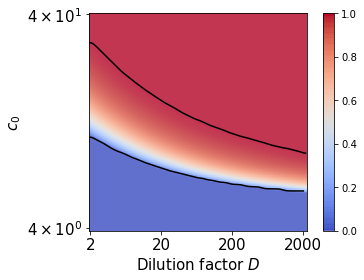

In [4]:
file = open("data/2species_abund.pkl",'rb')
bug0_abund, bug1_abund = pickle.load(file)
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d

N=100
ratio = bug1_abund/(bug0_abund+bug1_abund)
ax = plt.gca()
im=plt.imshow(np.flip(ratio, axis=0), cmap="coolwarm", alpha=0.8)
plt.xlabel("Dilution factor $D$", fontsize=15)
plt.ylabel("$c_0$", fontsize=15)
Dlabels = np.array([2, 20, 200, 2000])
def x2xgrid(D, Drange, xgrids=N):
    return (xgrids-1)*(np.log10(D/2)-Drange[0])/(Drange[1]-Drange[0])
xlabels = Dlabels
xticks = x2xgrid(Dlabels, Drange=[0, 3])
plt.xticks(xticks, xlabels, fontsize=15)
plt.yticks([0, 99], [r'$4\times10^1$', r'$4\times10^0$'], fontsize=15)
cbar = plt.colorbar(alpha=0.8)

mat = np.flip(ratio, axis=0)
clistl = []
clisth = []
for d_idx in range(100):
    col = mat[:, d_idx]
    for idx, i in enumerate(col[:-1]):
        if(col[idx]<1 and col[idx-1]==1):
            clisth.append(idx)
        if(col[idx]>0 and col[idx+1]==0):
            clistl.append(idx)

X_Y_Spline = interp1d(range(100), clistl, kind = "cubic")
X_ = np.linspace(0, 99, 1000)
Y_ = X_Y_Spline(X_)
Y_ = gaussian_filter1d(Y_, sigma=15)
plt.plot(X_, Y_, color='k')

X_Y_Spline = make_interp_spline(range(100), clisth)
X_ = np.linspace(0, 100, 1000)
Y_ = X_Y_Spline(X_)
Y_ = gaussian_filter1d(Y_, sigma=15)
plt.plot(X_, Y_, color='k')
plt.show()

### For a given strain and fixed environment, find the range of the second strains's g and K range that can make them coexist in a steady state. 

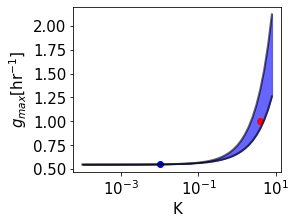

In [14]:
def g_inv(g0, K0, K1, c0, D):
    A = c0*D/(D-1)
    ginvLower = g0*(A+K1)*log(D)/((A+K0)*log(D)+(K0-K1)*np.log((c0+K1)/(K1)))
    ginvHigher = g0*((A+K1)*log(D)-(K0-K1)*np.log((c0+K0)/K0))/((A+K0)*log(D))
    return [ginvLower, ginvHigher]

g0, K0 = bug0[0], bug0[1]
c0, D = 10, 10
Klist = K0*10**np.arange(-2, 3, 0.1)
gllist = [g_inv(g0, K0, i, c0, D)[0] for i in Klist]
ghlist = [g_inv(g0, K0, i, c0, D)[1] for i in Klist]

fig, axs = plt.subplots(1, 1, figsize=(4, 3),
                            constrained_layout=True, squeeze=False)
plt.plot(Klist, gllist, color = 'k', alpha=0.6, lw=2)
plt.plot(Klist, ghlist, color = 'k', alpha=0.6, lw=2)
plt.fill_between(Klist, gllist, ghlist, color = 'b', alpha=0.6)
plt.scatter(bug0[1], bug0[0], color='b')
plt.scatter(bug1[1], bug1[0], color='r')
plt.xscale("log")
plt.xlabel("K", fontsize=15)
plt.ylabel("$g_{max}$[hr$^{-1}$]", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Find the coexistence of 3 strains in a single resource:

Fix 2 strains and an environment where there is already a pairwise coexistence, search for a strain that has traits between them, which can form a three-strain coexistence. 

In [6]:
bug0 = [0.55, 0.01]
bug1 = [1, 4]
c0, D, t, n, fluc_thres, elim_thres = 10, 10, 24.0, 10000, 1e-5, 2.0e-7
grange = [bug0[0], bug1[0]]
logKrange = [log(bug0[1]), log(bug1[1])]
Ng, NK = 50, 50
glist = np.arange(grange[1], grange[0]-0.00001, -(grange[1]-grange[0])/(Ng-1))
logKlist = np.arange(logKrange[0], logKrange[1]+0.00001, (logKrange[1]-logKrange[0])/(NK-1))
coex_map_1 = np.zeros([Ng, NK])
coex_ab_1 = [[[] for i in range(NK)] for j in range(Ng)]

# find the pairwise coexistence allowance
for gidx, g in enumerate(glist):
    for logKidx, logK in enumerate(logKlist):
        buginv = [g, exp(logK)]
        paretobugs = findCoexistPareto([bug0, buginv, bug1], c0, D)
        # if any 2 out of the 3 strains can coexist
        if(len(paretobugs)==3):
            coex_map_1[gidx, logKidx] = 1
            gs_pareto = np.array([i[0] for i in paretobugs])
            Ks_pareto = np.array([i[1] for i in paretobugs])
            p = len(gs_pareto), gs_pareto, Ks_pareto, 0
            p_dilute = c0, D, t, n, fluc_thres, elim_thres
            u_end = np.array([3, 3, 3]+[0.0])
            profile = Dilute(p, p_dilute, u_end, 1)
            # if all 3 strains can indeed coexist
            if(sum(profile[-1][:-1]>0)>=3):
                print("abundance:", profile[-1][:-1], "g:", g, "K:", exp(logK))
                coex_map_1[gidx, logKidx] = 2
                coex_ab_1[gidx][logKidx] = list(profile[-1][:-1])
                
abundance_data = coex_map_1, coex_ab_1, glist, logKlist
pickle.dump(abundance_data,open("data/abundance_data_large.pkl", "wb"))

abundance: [4.08361319e+00 1.20769843e-03 7.02629022e+00] g: 0.6969387755102041 K: 1.0421352232326626
abundance: [3.50400053 1.4717102  6.13540038] g: 0.6602040816326531 K: 0.7221281575281977
abundance: [2.84042545 3.02713219 5.24355347] g: 0.6510204081632653 K: 0.6390149435663546
abundance: [ 0.25341206 10.35715545  0.5005436 ] g: 0.6418367346938776 K: 0.500385232424534
abundance: [2.73700457 3.0815622  5.29254435] g: 0.6418367346938776 K: 0.5654676304256512
abundance: [0.41307574 8.96031226 1.73772311] g: 0.6326530612244898 K: 0.44279348163586196
abundance: [3.13024712 2.01588065 5.96498334] g: 0.6326530612244898 K: 0.500385232424534
abundance: [0.7799515  7.19738026 3.13377935] g: 0.6234693877551021 K: 0.39183024332912997
abundance: [4.08379418e+00 3.82913448e-04 7.02693402e+00] g: 0.6234693877551021 K: 0.44279348163586196
abundance: [1.60347581 4.78163482 4.72600048] g: 0.6142857142857143 K: 0.346732610019819
abundance: [3.62562465 0.77798968 6.70749678] g: 0.6051020408163266 K: 0.

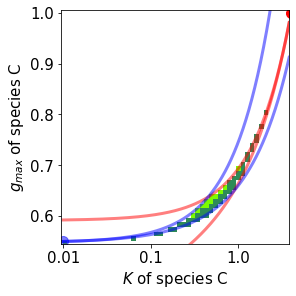

In [40]:
coex_map_1, coex_ab_1, glist, logKlist = pickle.load(open("data/abundance_data_large.pkl", "rb"))

colormaps = [ListedColormap(['w', 'seagreen', 'lawngreen'])]
fig, axs = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True, squeeze=False)
for [ax, cmap] in zip(axs.flat, colormaps):
    psm = ax.pcolormesh(coex_map_1, cmap=cmap, rasterized=True, vmin=0, vmax=2)
    
g_red, K_red = 1, 4
g_orange, K_orange = 0.55, 0.01
x, y = coex_map_1.shape[0], coex_map_1.shape[1]
def K2xgrid(K, Klow=K_orange, Khigh=K_red, xgrids=x):
    return (xgrids-0.1)*(np.log10(K)-log10(Klow))/(log10(Khigh)-log10(Klow))
def g2ygrid(g, glow=g_orange, ghigh=g_red, ygrids=y):
    return (ygrids-1)*(ghigh-g)/(ghigh-glow)

#plot the coexistence region of red strain at topright
def g_inv(g0, K0, K1, c0, D):
    A = c0*D/(D-1)
    ginvLower = g0*(A+K1)*log(D)/((A+K0)*log(D)+(K0-K1)*np.log((c0+K1)/(K1)))
    ginvHigher = g0*((A+K1)*log(D)-(K0-K1)*np.log((c0+K0)/K0))/((A+K0)*log(D))
    return [ginvLower, ginvHigher]

g_high, g_low, K_high, K_low = g_red, g_orange, K_red, K_orange
K_list = 10**np.arange(log10(K_low), log10(K_high), -(log10(K_low)-log10(K_high))/1000)
g_list_red = np.array([g_inv(g_red, K_red, i, c0, D) for i in K_list])
plt.plot(K2xgrid(K_list), g2ygrid(g_list_red[:, 0]), color = 'r', lw=3, alpha=0.5)
plt.plot(K2xgrid(K_list), g2ygrid(g_list_red[:, 1]), color = 'r', lw=3, alpha=0.5)
g_list_orange = np.array([g_inv(g_orange, K_orange, i, c0, D) for i in K_list])
plt.plot(K2xgrid(K_list), g2ygrid(g_list_orange[:, 0]), color = 'b', lw=3, alpha=0.5)
plt.plot(K2xgrid(K_list), g2ygrid(g_list_orange[:, 1]), color = 'b', lw=3, alpha=0.5)

plt.scatter(K2xgrid(K_orange), g2ygrid(g_orange), color='b', alpha=0.5, s=100)
plt.scatter(K2xgrid(K_red), g2ygrid(g_red), color='r', s=100)

ax=plt.gca()
plt.xticks([])
ax.set_xticklabels([])
plt.yticks([])
ax.set_yticklabels([])
plt.xlim(-0.5, 49.5)
plt.ylim(49.5, -0.5)
plt.xlabel("$K$ of species C", fontsize=15)
plt.ylabel("$g_{max}$ of species C", fontsize=15)
glabels = np.array([0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks(g2ygrid(glabels), glabels, fontsize=15)
Klabels = ["$10^{-2}$", "$10^{-1}$", "$10^{0}$"]
Kticklist = np.array([0.01, 0.1, 1])
plt.xticks(K2xgrid(Kticklist), Kticklist, fontsize=15)
gticks = np.arange(grange[1], grange[0]-0.00001, -(grange[1]-grange[0])/10)
Kticks = np.arange(logKrange[0], logKrange[1]+0.00001, (logKrange[1]-logKrange[0])/10)

plt.show()

In the above plot, light green = steady 3-species coexistence, and dark green = steady coeixtence of any 2 strains out of the 3, but no steady 3-species coexistence. 

### Run a separate simulation for the region around the light green region to see the details of the 3-species coexistence:

In [6]:
bug0 = [0.55, 0.01]
bug1 = [1, 4]
c0, D, t, n, fluc_thres, elim_thres = 10, 10, 24.0, 10000, 1e-5, 2.0e-7
grange = [bug0[0], bug1[0]]
logKrange = [log(bug0[1]), log(bug1[1])]
Ng, NK = 50, 50
g_high, g_low, K_high, K_low = 0.7, 0.6, 1.05, 0.25
grange = [g_low, g_high]
logKrange = [log(K_low), log(K_high)]
glist = np.arange(grange[1], grange[0]-0.00001, -(grange[1]-grange[0])/(Ng-1))
logKlist = np.arange(logKrange[0], logKrange[1]+0.00001, (logKrange[1]-logKrange[0])/(NK-1))
coex_map_2 = np.zeros([Ng, NK])
coex_ab_2 = [[[] for i in range(NK)] for j in range(Ng)]
for gidx, g in enumerate(glist):
    for logKidx, logK in enumerate(logKlist):
        buginv = [g, exp(logK)]
        paretobugs = findCoexistPareto([bug0, buginv, bug1], c0, D)
        if(len(paretobugs)==3):
            coex_map_2[gidx, logKidx] = 1
            gs_pareto = np.array([i[0] for i in paretobugs])
            Ks_pareto = np.array([i[1] for i in paretobugs])
            p = len(gs_pareto), gs_pareto, Ks_pareto, 0
            p_dilute = c0, D, t, n, fluc_thres, elim_thres
            u_end = np.array([3, 3, 3]+[0.0])
            profile = Dilute(p, p_dilute, u_end, 1)
            if(sum(profile[-1][:-1]>0)>=3):
                print("abundance:", profile[-1][:-1], "g:", g, "K:", exp(logK))
                coex_map_2[gidx, logKidx] = 2
                coex_ab_2[gidx][logKidx] = list(profile[-1][:-1])
                
abundance_data = coex_map_2, coex_ab_2, glist, logKlist
pickle.dump(abundance_data,open("data/abundance_data_details.pkl", "wb"))

abundance: [4.07620442 0.02509874 7.00980795] g: 0.6979591836734693 K: 1.050000000000005
abundance: [3.62215212 1.4431368  6.04582219] g: 0.6918367346938774 K: 0.9902630001529965
abundance: [4.08055536 0.01030236 7.02025339] g: 0.6877551020408161 K: 0.9616813177724638
abundance: [3.36599746 2.17407875 5.5710349 ] g: 0.6857142857142855 K: 0.9339245804495324
abundance: [2.75917215 4.05768753 4.29425143] g: 0.6836734693877549 K: 0.9069689780270884
abundance: [3.96192964 0.35247231 6.79670916] g: 0.6816326530612242 K: 0.9069689780270884
abundance: [3.30056404 2.28221873 5.52832834] g: 0.6795918367346936 K: 0.8807913875738841
abundance: [2.77318619 3.8495546  4.48837032] g: 0.677551020408163 K: 0.8553693535493311
abundance: [2.34674501 5.12923934 3.63512676] g: 0.6755102040816323 K: 0.8306810685407916
abundance: [3.99064053 0.25863288 6.8618377 ] g: 0.6755102040816323 K: 0.8553693535493311
abundance: [1.99947444 6.18067573 2.93096095] g: 0.6734693877551017 K: 0.8067053545568437
abundance: [

abundance: [3.5239387  1.17142777 6.41574464] g: 0.6326530612244889 K: 0.5048995309462146
abundance: [0.30294775 9.18247984 1.62568352] g: 0.6306122448979583 K: 0.42353443661668344
abundance: [0.60906878 8.1666821  2.33536023] g: 0.6306122448979583 K: 0.43612210627489767
abundance: [1.03444185 6.93339519 3.14327406] g: 0.6306122448979583 K: 0.4490838881981973
abundance: [1.62727627 5.40191268 4.08192216] g: 0.6306122448979583 K: 0.46243090120290703
abundance: [2.44853275 3.47739154 5.18518683] g: 0.6306122448979583 K: 0.47617459456251143
abundance: [3.60582652 0.98355709 6.5217275 ] g: 0.6306122448979583 K: 0.49032675782901747
abundance: [0.34260093 8.8765073  1.89200288] g: 0.6285714285714277 K: 0.4113100813264973
abundance: [0.65993539 7.87070255 2.58047317] g: 0.6285714285714277 K: 0.42353443661668344
abundance: [1.09908904 6.64503936 3.36698271] g: 0.6285714285714277 K: 0.43612210627489767
abundance: [1.70762173 5.12221746 4.28127193] g: 0.6285714285714277 K: 0.4490838881981973
abu

In [43]:
coex_map_2, coex_ab_2, glist, logKlist = pickle.load(open("data/abundance_data_details.pkl", "rb"))

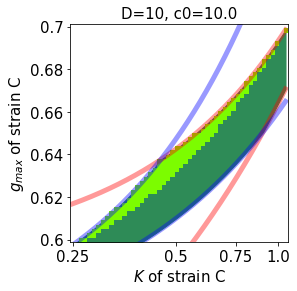

In [44]:
g_red, K_red = 1, 4
g_orange, K_orange = 0.55, 0.01
def g_inv(g0, K0, K1, c0, D):
    A = c0*D/(D-1)
    ginvLower = g0*(A+K1)*log(D)/((A+K0)*log(D)+(K0-K1)*np.log((c0+K1)/(K1)))
    ginvHigher = g0*((A+K1)*log(D)-(K0-K1)*np.log((c0+K0)/K0))/((A+K0)*log(D))
    return [ginvLower, ginvHigher]
def K2xgrid(K, Klow=K_orange, Khigh=K_red, xgrids=NK):
    return (xgrids-1)*(np.log10(K)-log10(Klow))/(log10(Khigh)-log10(Klow))
def g2ygrid(g, glow=g_orange, ghigh=g_red, ygrids=Ng):
    return (ygrids-1)*(ghigh-g)/(ghigh-glow)

colormaps = [ListedColormap(['w', 'seagreen', 'lawngreen'])]
K_list = 10**np.arange(log10(K_low), log10(K_high), -(log10(K_low)-log10(K_high))/1000)
g_list_red = np.array([g_inv(g_red, K_red, i, c0, D) for i in K_list])
g_list_orange = np.array([g_inv(g_orange, K_orange, i, c0, D) for i in K_list])
    
x = K2xgrid(K_list, K_low, K_high)
y_rl = g2ygrid(g_list_red[:, 0], g_low, g_high)
y_rh = g2ygrid(g_list_red[:, 1], g_low, g_high)
y_ol = g2ygrid(g_list_orange[:, 0], g_low, g_high)
y_oh = g2ygrid(g_list_orange[:, 1], g_low, g_high)
plt.plot(x, y_rl, color = 'r', alpha=0.4, lw=5, zorder=1)
plt.plot(x, y_rh, color = 'r', alpha=0.4, lw=5, zorder=1)
plt.plot(x, y_ol, color = 'b', alpha=0.4, lw=5, zorder=1)
plt.plot(x, y_oh, color = 'b', alpha=0.4, lw=5, zorder=1)
palette = np.array([[255, 255, 255, 1],
                    [255, 255, 255, 1],
                    [  124, 252, 0, 255]])  # lawngreen
plt.imshow(palette[coex_map_2.astype(int)], zorder=0)

plt.fill_between(x, np.maximum(y_rh, y_oh), np.minimum(y_rl, y_ol), color = 'seagreen', alpha=1, zorder=0)

g_high, g_low, K_high, K_low = 0.7, 0.6, 1.05, 0.25
ax=plt.gca()
plt.xlabel("$K$ of strain C", fontsize=15)
plt.ylabel("$g_{max}$ of strain C", fontsize=15)
glabels = np.array([0.60, 0.62, 0.64, 0.66, 0.68, 0.70])
plt.yticks(g2ygrid(glabels, g_low, g_high), glabels, fontsize=15)
Klabels = ["$10^{-2}$", "$10^{-1}$", "$10^{0}$"]
Kticklist = np.array([round(0.25*(i+1), 3) for i in range(4)])
plt.xticks(K2xgrid(Kticklist, K_low, K_high), Kticklist, fontsize=15)
plt.xlim(-0.5, 49.5)
plt.ylim(49.5, -0.5)
plt.title("D="+str(D)+", c0="+str(c0), fontsize=15)

plt.show()

Here the diversity of the final community can be 1 (only C), 2 (AB, AC, BC), and 3 (ABC), depending on the traits of strain C. We can show the diversity in the above plot, and show the corresponding abundance of each strain in some specific points. We will take 4 possible strain C (marked as yellow), where the community would be respectively C, BC, ABC and AB.

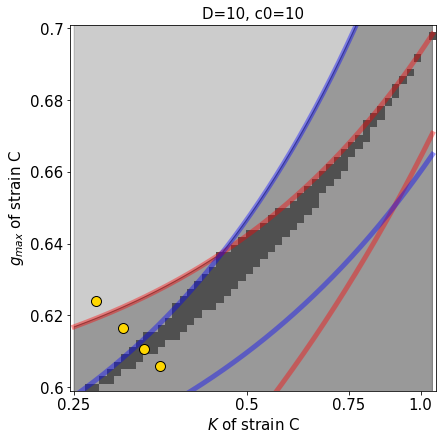

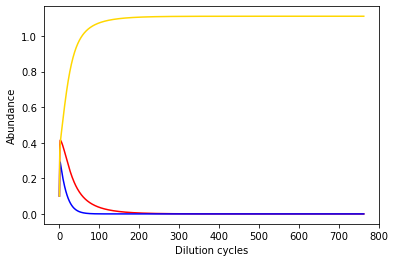

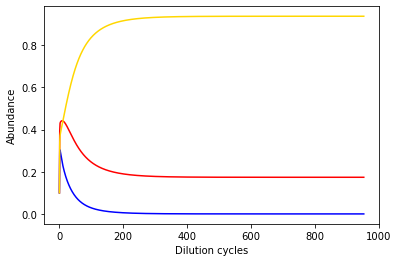

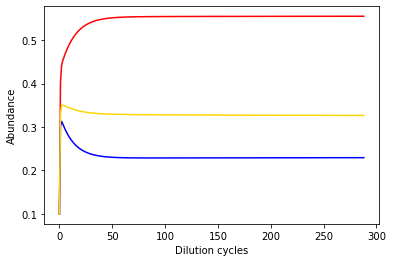

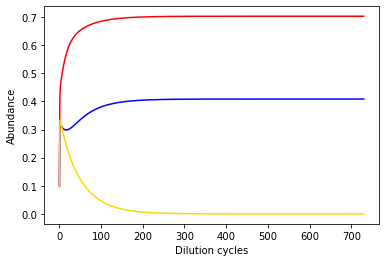

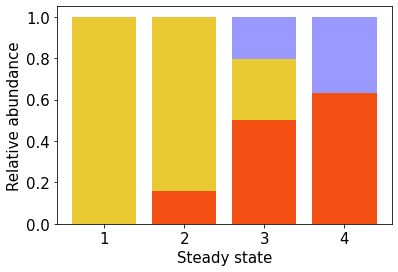

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(6, 6),
                            constrained_layout=True, squeeze=False)
plt.plot(x, y_rl, color = 'r', alpha=0.4, lw=5, zorder=1)
plt.plot(x, y_rh, color = 'r', alpha=0.4, lw=5, zorder=1)
plt.plot(x, y_ol, color = 'b', alpha=0.4, lw=5, zorder=1)
plt.plot(x, y_oh, color = 'b', alpha=0.4, lw=5, zorder=1)
palette = np.array([[255, 255, 255, 1],
                    [255,   0,   0, 1],   # red
                    [  80, 80, 80, 255],   # green
                    [  0,   0, 255, 1]])  # blue
plt.imshow(palette[coex_map_2.astype(int)], zorder=0)

plt.fill_between(x, np.minimum(y_rh, y_oh), [-1 for i in x], color = 'k', alpha=0.2, zorder=0)
plt.fill_between(x, np.minimum(y_rh, y_oh), [100 for i in x], color = 'k', alpha=0.4, zorder=0)
    
x1, x2, y1, y2 = -0.956, -1.386, 0.6, 0.63
c_slice = 'gold'
p1x = x1 + (x2-x1)*1/5
p1y = y1 + (y2-y1)*1/5
p2x = x1 + (x2-x1)*0.35
p2y = y1 + (y2-y1)*0.35
p3x = x1 + (x2-x1)*0.55
p3y = y1 + (y2-y1)*0.55
p4x = x1 + (x2-x1)*0.8
p4y = y1 + (y2-y1)*0.8
c_edge='k'
plt.scatter(K2xgrid(exp(p1x), K_low, K_high), g2ygrid(p1y, g_low, g_high), color = c_slice, s=100, edgecolors=c_edge, zorder=2)
plt.scatter(K2xgrid(exp(p2x), K_low, K_high), g2ygrid(p2y, g_low, g_high), color = c_slice, s=100, edgecolors=c_edge, zorder=2)
plt.scatter(K2xgrid(exp(p3x), K_low, K_high), g2ygrid(p3y, g_low, g_high), color = c_slice, s=100, edgecolors=c_edge, zorder=2)
plt.scatter(K2xgrid(exp(p4x), K_low, K_high), g2ygrid(p4y, g_low, g_high), color = c_slice, s=100, edgecolors=c_edge, zorder=2)

g_high, g_low, K_high, K_low = 0.7, 0.6, 1.05, 0.25
ax=plt.gca()
plt.xlabel("$K$ of strain C", fontsize=15)
plt.ylabel("$g_{max}$ of strain C", fontsize=15)
glabels = np.array([0.60, 0.62, 0.64, 0.66, 0.68, 0.70])
plt.yticks(g2ygrid(glabels, g_low, g_high), glabels, fontsize=15)
Klabels = ["$10^{-2}$", "$10^{-1}$", "$10^{0}$"]
Kticklist = np.array([round(0.25*(i+1), 3) for i in range(4)])
plt.xticks(K2xgrid(Kticklist, K_low, K_high), Kticklist, fontsize=15)
plt.xlim(-0.5, 49.5)
plt.ylim(49.5, -0.5)
plt.title("D="+str(D)+", c0="+str(c0), fontsize=15)

plt.show()

# Do the simulation for all these cases
xs = [p4x, p3x, p2x, p1x]
ys = [p4y, p3y, p2y, p1y]
red, orange, yellow = [], [], []
for i in range(4):
    all_gmax = [1, 0.55, ys[i]]
    all_Ks = [4, 0.01, exp(xs[i])]
    gs_all, Ks_all = np.array(all_gmax), np.array(all_Ks)
    x = 1
    p = len(gs_all), gs_all, Ks_all, 0
    c0, D, t, n, fluc_thres, elim_thres = 10.0, 10, 24.0, 10000, 1e-5, 2.0e-7
    p_dilute = c0, D, t, n, fluc_thres, elim_thres
    u_end = np.array([1.0 for i in gs_all]+[0.0])
    profile = Dilute(p, p_dilute, u_end, x)
    rel_abundance = profile[-1, :-1]/sum(profile[-1, :-1])
    red.append(rel_abundance[0])
    orange.append(rel_abundance[1])
    yellow.append(rel_abundance[2])
    colors = ['r', 'b', 'gold']
    for i in range(profile.shape[1]-1):
        plt.plot(range(profile.shape[0]), profile[0:, i]/D, color = colors[i])
    plt.xlabel("Dilution cycles")
    plt.ylabel("Abundance")
    plt.show()
    
fig, ax = plt.subplots()
labels = [1, 2, 3, 4]
plt.bar(labels, np.array(red)+np.array(yellow)+np.array(orange), color = 'b', alpha = 0.4)
plt.bar(labels, np.array(red)+np.array(yellow), color = 'gold', alpha = 0.8)
plt.bar(labels, red, color = 'red', alpha = 0.6)
plt.xticks([1, 2, 3, 4], fontsize=15)
plt.xlabel("Steady state", fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Relative abundance", fontsize=15)
plt.show()